In [103]:
import numpy as np
import pandas as pd
import os
import json
import warnings
import time
from datetime import datetime
from dataclasses import dataclass
from typing import Optional, List, Dict, Any

# Optuna for optimization
import optuna
from optuna.samplers import TPESampler

# MLForecast
from mlforecast import MLForecast
from mlforecast.auto import AutoMLForecast, AutoModel
from mlforecast.lag_transforms import (
    RollingMean, 
    RollingStd, 
    ExpandingMean,
    ExponentiallyWeightedMean,
)

# Models
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

# Evaluation
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, mse, rmse

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

## General config

In [104]:
user = "Lilian"  # Your username for paths

# Paths
DATA_PATH = rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\merged_data\Prebuilt_panels\P1_ML.csv"
OUTPUT_PATH = rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\Forecast\ML\\"

# Target selection
TARGET = 'y'  # 'y' = Units Reimbursed, 'y_1' = Number of Prescriptions
TARGET_NAME = 'Units Reimbursed' if TARGET == 'y' else 'Number of Prescriptions'

# State filtering (None = all states)
STATES = ['IN']  # Options: None, ['IN'], ['IN', 'OH', 'IL', 'MI'], etc.

# Optimization settings
NUM_SAMPLES = 30  # Optuna trials per model (increase to 50-100 for production)

In [105]:
@dataclass
class MLForecastConfig:
    
    # Target
    target_col: str = TARGET
    target_name: str = TARGET_NAME
    
    # Forecast parameters
    horizon: int = 8  # Quarters to forecast
    season_length: int = 4
    freq: str = 'QS'
    
    # Cross-validation
    n_windows: int = 2 # Look carefully at this since we have few observations. The reasonable maximum is 3 (if it runs ofc)
    step_size: int = 4  
    
    train_start: str = '2017-01-01'
    train_end: str = '2024-10-01'
    
    n_jobs: int = -1
    random_state: int = 42

config = MLForecastConfig()

## Section 1: Load Pre-Built Panel and Validate it

In [106]:
# Load pre-built panel
df = pd.read_csv(DATA_PATH)
df['ds'] = pd.to_datetime(df['ds'])

print(f"\nPanel Loaded: P1_ML.csv")
print(f"   • Shape: {df.shape}")
print(f"   • Columns: {df.columns.tolist()}")

df.head()


Panel Loaded: P1_ML.csv
   • Shape: (133414, 7)
   • Columns: ['unique_id', 'ds', 'y', 'y_1', 'population', 'population_low', 'population_high']


,unique_id,ds,y,y_1,population,population_low,population_high
0,AK_A01,2017-01-01,36119.500,1235.0,180677.666667,NaN,NaN
1,AK_A01,2017-04-01,70157.400,2369.0,184889.333333,NaN,NaN
2,AK_A01,2017-07-01,58421.290,1624.0,184185.666667,NaN,NaN
3,AK_A01,2017-10-01,65281.208,2537.0,193784.666667,NaN,NaN
4,AK_A01,2018-01-01,50398.410,1365.0,196836.333333,NaN,NaN


In [107]:
# Filter states if specified
if STATES is not None:
    df['state'] = df['unique_id'].str.split('_').str[0]
    df = df[df['state'].isin(STATES)].copy()
    df = df.drop(columns=['state'])
    print(f"\nFiltered to states: {STATES}")
    print(f"   • Remaining series: {df['unique_id'].nunique()}")
    print(f"   • Remaining rows: {len(df):,}")
else:
    print(f"\nUsing all states")
    print(f"   • Total series: {df['unique_id'].nunique()}")


Filtered to states: ['IN']
   • Remaining series: 83
   • Remaining rows: 3,308


In [108]:
# Panel validation

print("\nPanel Validation:")
print("-" * 40)

required = ['unique_id', 'ds', 'y', 'population']
missing = [c for c in required if c not in df.columns]
print(f"Required columns: {'PASS' if not missing else f'FAIL - Missing: {missing}'}")

n_dups = df.groupby(['unique_id', 'ds']).size().gt(1).sum()
print(f"Duplicate check: {'PASS' if n_dups == 0 else f'FAIL - {n_dups} duplicates'}")

print(f"Missing 'y': {df['y'].isna().sum()}")
print(f"Missing 'population': {df['population'].isna().sum()}")


Panel Validation:
----------------------------------------
Required columns: PASS
Duplicate check: PASS
Missing 'y': 664
Missing 'population': 0


In [109]:
# Checking df for training

HISTORICAL_CUTOFF = pd.to_datetime(config.train_end)

df_historical = df[df['ds'] <= HISTORICAL_CUTOFF].copy()
df_future = df[df['ds'] > HISTORICAL_CUTOFF].copy()

print(f"\nData Split:")
print(f"  Historical: {len(df_historical):,} rows (up to {HISTORICAL_CUTOFF.strftime('%Y-%m-%d')})")
print(f"  Future: {len(df_future):,} rows")


Data Split:
  Historical: 2,644 rows (up to 2024-10-01)
  Future: 664 rows


In [110]:
#Dropping uncomplete series
print("\nBalancing Panel:")
print("-" * 40)

all_dates = sorted(df_historical['ds'].unique())
n_dates = len(all_dates)

series_lengths = df_historical.groupby('unique_id').size()
complete_series = series_lengths[series_lengths == n_dates].index

print(f"Total dates: {n_dates}")
print(f"Complete series: {len(complete_series)}")
print(f"Incomplete series: {len(series_lengths) - len(complete_series)} (removed)")

df_historical = df_historical[df_historical['unique_id'].isin(complete_series)].copy()
df_future = df_future[df_future['unique_id'].isin(complete_series)].copy()


Balancing Panel:
----------------------------------------
Total dates: 32
Complete series: 80
Incomplete series: 3 (removed)


In [111]:
# Create training dataframe
train_df = df_historical[['unique_id', 'ds', TARGET, 'population']].copy()
train_df.columns = ['unique_id', 'ds', 'y', 'population']
train_df = train_df.sort_values(['unique_id', 'ds']).reset_index(drop=True)

print(f"\nTraining DataFrame:")
print(f"  Shape: {train_df.shape}")
print(f"  Series: {train_df['unique_id'].nunique()}")
print(f"  Date range: {train_df['ds'].min().strftime('%Y-%m-%d')} to {train_df['ds'].max().strftime('%Y-%m-%d')}")

train_df.head()


Training DataFrame:
  Shape: (2560, 4)
  Series: 80
  Date range: 2017-01-01 to 2024-10-01


,unique_id,ds,y,population
0,IN_A01,2017-01-01,730341.008,1.340711e+06
1,IN_A01,2017-04-01,941647.286,1.344308e+06
2,IN_A01,2017-07-01,2454204.293,1.352133e+06
3,IN_A01,2017-10-01,2827659.245,1.349519e+06
4,IN_A01,2018-01-01,303934.436,1.343081e+06


In [112]:
# Create future exogenous dataframes
print("\nFuture Exogenous:")

if len(df_future) > 0 and df_future['population'].notna().any():
    X_future_point = df_future[['unique_id', 'ds', 'population']].copy()
    X_future_point = X_future_point.sort_values(['unique_id', 'ds']).reset_index(drop=True)
    print(f"  X_future_point: {X_future_point.shape}")
else:
    # Create from last known values
    print("  Creating from last known values...")
    last_date = train_df['ds'].max()
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=3), 
                                  periods=config.horizon, freq=config.freq)
    future_rows = []
    for uid in train_df['unique_id'].unique():
        last_pop = train_df[train_df['unique_id'] == uid]['population'].iloc[-1]
        for date in future_dates:
            future_rows.append({'unique_id': uid, 'ds': date, 'population': last_pop})
    X_future_point = pd.DataFrame(future_rows)
    print(f"  X_future_point: {X_future_point.shape}")

# Low/High scenarios
X_future_low = None
X_future_high = None

if 'population_low' in df_future.columns and df_future['population_low'].notna().any():
    X_future_low = df_future[['unique_id', 'ds', 'population_low']].copy()
    X_future_low.columns = ['unique_id', 'ds', 'population']
    X_future_low = X_future_low.sort_values(['unique_id', 'ds']).reset_index(drop=True)
    print(f"  X_future_low: {X_future_low.shape}")

if 'population_high' in df_future.columns and df_future['population_high'].notna().any():
    X_future_high = df_future[['unique_id', 'ds', 'population_high']].copy()
    X_future_high.columns = ['unique_id', 'ds', 'population']
    X_future_high = X_future_high.sort_values(['unique_id', 'ds']).reset_index(drop=True)
    print(f"  X_future_high: {X_future_high.shape}")


Future Exogenous:
  X_future_point: (640, 3)
  X_future_low: (640, 3)
  X_future_high: (640, 3)


## Section 2: Search Spaces for AutoMLForecast
#### AutoMLForecast from mlforecast library tunes:
1. Model parameters via `config` function (defined above) 
2. Features (lags,transforms) via `init_config` function

In [113]:
print("=" * 60); print("SECTION 2: DEFINE SEARCH SPACES"); print("=" * 60)

def lgb_config(trial: optuna.Trial) -> dict:
    """LightGBM hyperparameter search space."""
    return {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 8, 128, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'verbosity': -1,
        'random_state': config.random_state,
        'n_jobs': config.n_jobs,
    }

def xgb_config(trial: optuna.Trial) -> dict:
    """XGBoost hyperparameter search space."""
    return {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 10, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'verbosity': 0,
        'random_state': config.random_state,
        'n_jobs': config.n_jobs,
    }

def rf_config(trial: optuna.Trial) -> dict:
    """RandomForest hyperparameter search space."""
    return {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'max_features': trial.suggest_float('max_features', 0.3, 1.0),
        'random_state': config.random_state,
        'n_jobs': config.n_jobs,
    }

def ridge_config(trial: optuna.Trial) -> dict:
    """Ridge hyperparameter search space."""
    return {
        'alpha': trial.suggest_float('alpha', 1e-3, 100.0, log=True),
        'random_state': config.random_state,
    }

print("\nModel search spaces defined:")
print("  - LightGBM: n_estimators, max_depth, learning_rate, reg_alpha, reg_lambda, ...")
print("  - XGBoost: n_estimators, max_depth, learning_rate, reg_alpha, reg_lambda, gamma, ...")
print("  - RandomForest: n_estimators, max_depth, min_samples_leaf, ...")
print("  - Ridge: alpha")

SECTION 2: DEFINE SEARCH SPACES

Model search spaces defined:
  - LightGBM: n_estimators, max_depth, learning_rate, reg_alpha, reg_lambda, ...
  - XGBoost: n_estimators, max_depth, learning_rate, reg_alpha, reg_lambda, gamma, ...
  - RandomForest: n_estimators, max_depth, min_samples_leaf, ...
  - Ridge: alpha


In [114]:

def my_init_config(trial: optuna.Trial) -> dict:
    """
    Tune MLForecast features: lags and lag_transforms.
    This is called during optimization to find the best feature configuration.
    """
    # Tune lags
    use_lag_3 = trial.suggest_categorical('use_lag_3', [True, False])
    use_lag_8 = trial.suggest_categorical('use_lag_8', [True, False])
    
    lags = [1, 2, 4]  # Base lags
    if use_lag_3:
        lags.append(3)
    if use_lag_8:
        lags.append(8)
    lags = sorted(lags)
    
    # Tune rolling window
    rolling_window = trial.suggest_categorical('rolling_window', [2, 4])
    
    # Tune expanding mean
    use_expanding = trial.suggest_categorical('use_expanding', [True, False])
    
    # Tune EWM
    use_ewm = trial.suggest_categorical('use_ewm', [True, False])
    ewm_alpha = trial.suggest_float('ewm_alpha', 0.1, 0.9) if use_ewm else 0.3
    
    # Build lag_transforms
    lag_transforms = {
        1: [RollingMean(window_size=rolling_window), RollingStd(window_size=rolling_window)],
    }
    
    if use_ewm:
        lag_transforms[1].append(ExponentiallyWeightedMean(alpha=ewm_alpha))
    
    if use_expanding:
        lag_transforms[4] = [ExpandingMean()]
    
    return {
        'lags': lags,
        'lag_transforms': lag_transforms,
        'date_features': ['quarter'],
    }

#This config is neccesary to avoid the error of missing fit parameters in static_features[] when running auto_mlf.fit()
def my_fit_config(trial: optuna.Trial) -> dict:
    """
    Parameters passed to MLForecast.fit()
    """
    return {
        'static_features': [],  # or ['unique_id'] or your static feature columns
        #'dropna': True  # Drop rows with NaNs after feature engineering
    }

print("\nFeature search space (init_config):")
print("  - Lags: [1,2,4] + optional [3,8]")
print("  - Rolling window: 2 or 4")
print("  - Expanding mean: True/False")
print("  - EWM: True/False with tunable alpha")


Feature search space (init_config):
  - Lags: [1,2,4] + optional [3,8]
  - Rolling window: 2 or 4
  - Expanding mean: True/False
  - EWM: True/False with tunable alpha


## Section 3: Run AutoMLForecast Optimization with Optuna

In [115]:
print("=" * 60); print("SECTION 3: AutoMLForecast OPTIMIZATION"); print("=" * 60)

# Create AutoModel instances
auto_lgb = AutoModel(model=lgb.LGBMRegressor(), config=lgb_config)
auto_xgb = AutoModel(model=xgb.XGBRegressor(), config=xgb_config)
auto_rf = AutoModel(model=RandomForestRegressor(), config=rf_config)
auto_ridge = AutoModel(model=Ridge(), config=ridge_config)

# Create AutoMLForecast
auto_mlf = AutoMLForecast(
    models={
        'LightGBM': auto_lgb,
        'XGBoost': auto_xgb,
        'RandomForest': auto_rf,
        'Ridge': auto_ridge,
    },
    freq=config.freq,
    season_length=config.season_length,
    init_config=my_init_config,
    fit_config=my_fit_config,
)

print("\nAutoMLForecast created:")
print(f"  Models: LightGBM, XGBoost, RandomForest, Ridge")
print(f"  Feature tuning: Enabled")

SECTION 3: AutoMLForecast OPTIMIZATION

AutoMLForecast created:
  Models: LightGBM, XGBoost, RandomForest, Ridge
  Feature tuning: Enabled


In [116]:
# Run optimization
print(f"\n{'='*60}")
print("RUNNING OPTIMIZATION")
print(f"{'='*60}")
print(f"  Trials per model: {NUM_SAMPLES}")
print(f"  CV windows: {config.n_windows}")
print(f"  Horizon: {config.horizon} quarters")
print(f"\n  This may take several minutes...\n")

start_time = time.time()

auto_mlf.fit(
    train_df,
    n_windows=config.n_windows,
    h=config.horizon,
    num_samples=NUM_SAMPLES,
)

elapsed = time.time() - start_time
print(f"\nOptimization complete!")
print(f"  Time: {elapsed/60:.1f} minutes")


RUNNING OPTIMIZATION
  Trials per model: 30
  CV windows: 2
  Horizon: 8 quarters

  This may take several minutes...


Optimization complete!
  Time: 1.1 minutes


## Section 4: Analyze Optimization Results

In [117]:
print("=" * 60); print("SECTION 4: OPTIMIZATION RESULTS"); print("=" * 60)

# Summary table
results_summary = []
for model_name, study in auto_mlf.results_.items():
    results_summary.append({
        'Model': model_name,
        'Best_CV_MAE': study.best_value,
        'Num_Trials': len(study.trials),
    })

results_df = pd.DataFrame(results_summary).sort_values('Best_CV_MAE')
best_model_name = results_df.iloc[0]['Model']
best_model_score = results_df.iloc[0]['Best_CV_MAE']

print("\nModel Comparison (sorted by CV MAE):")
print(results_df.to_string(index=False))
print(f"\nBest Model: {best_model_name} (MAE: {best_model_score:,.2f})")

SECTION 4: OPTIMIZATION RESULTS

Model Comparison (sorted by CV MAE):
       Model  Best_CV_MAE  Num_Trials
RandomForest     0.178603          30
     XGBoost     0.222911          30
    LightGBM     0.223958          30
       Ridge     0.248330          30

Best Model: RandomForest (MAE: 0.18)


In [118]:
# Best configurations
print("\n" + "=" * 60); print("BEST CONFIGURATIONS"); print("=" * 60)

best_configs = {}

for model_name, study in auto_mlf.results_.items():
    print(f"\n{model_name}:")
    print("-" * 40)
    
    best_config = study.best_trial.user_attrs['config']
    best_configs[model_name] = best_config
    
    # Key model parameters
    model_params = best_config.get('model_params', {})
    key_params = ['n_estimators', 'max_depth', 'learning_rate', 'reg_alpha', 'reg_lambda', 'alpha']
    print("  Key params:")
    for k in key_params:
        if k in model_params:
            v = model_params[k]
            print(f"    {k}: {v:.4f}" if isinstance(v, float) else f"    {k}: {v}")
    
    # Features
    init_params = best_config.get('mlf_init_params', {})
    print(f"  Lags: {init_params.get('lags', 'default')}")
    print(f"  CV MAE: {study.best_value:,.2f}")


BEST CONFIGURATIONS

LightGBM:
----------------------------------------
  Key params:
    n_estimators: 393
    max_depth: 9
    learning_rate: 0.0398
    reg_alpha: 0.0013
    reg_lambda: 0.0000
  Lags: [1, 2, 3, 4, 8]
  CV MAE: 0.22

XGBoost:
----------------------------------------
  Key params:
    n_estimators: 264
    max_depth: 8
    learning_rate: 0.0239
    reg_alpha: 0.0000
    reg_lambda: 6.1635
  Lags: [1, 2, 3, 4, 8]
  CV MAE: 0.22

RandomForest:
----------------------------------------
  Key params:
    n_estimators: 334
    max_depth: 10
  Lags: [1, 2, 3, 4, 8]
  CV MAE: 0.18

Ridge:
----------------------------------------
  Key params:
    alpha: 0.0011
  Lags: [1, 2, 4, 8]
  CV MAE: 0.25


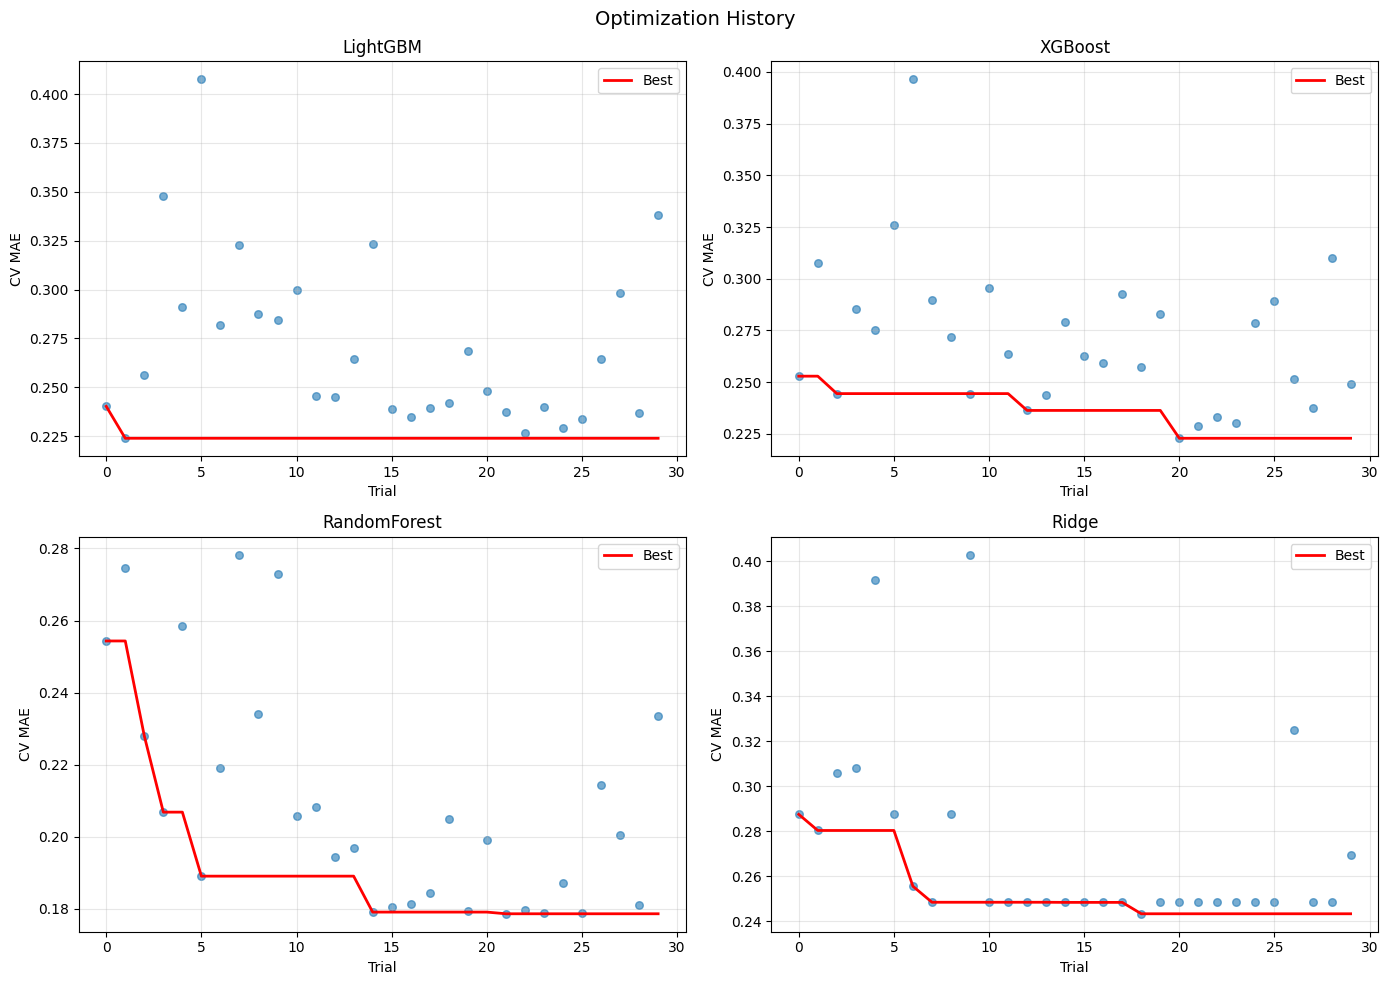

In [119]:
# Optimization history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (model_name, study) in enumerate(auto_mlf.results_.items()):
    if idx >= 4:
        break
    ax = axes[idx]
    
    trial_values = [t.value for t in study.trials]
    ax.scatter(range(len(trial_values)), trial_values, alpha=0.6, s=30)
    
    # Best so far line
    best_so_far = [min(trial_values[:i+1]) for i in range(len(trial_values))]
    ax.plot(range(len(best_so_far)), best_so_far, 'r-', linewidth=2, label='Best')
    
    ax.set_xlabel('Trial')
    ax.set_ylabel('CV MAE')
    ax.set_title(f'{model_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Optimization History', fontsize=14)
plt.tight_layout()
plt.show()

## Section 5: Generating Forecasts

In [120]:
print("=" * 60); print("SECTION 5: GENERATE FORECASTS"); print("=" * 60)

print("\nFitted Models:")
for model_name in auto_mlf.models_.keys():
    print(f"  - {model_name}")

SECTION 5: GENERATE FORECASTS

Fitted Models:
  - LightGBM
  - XGBoost
  - RandomForest
  - Ridge


In [121]:
# Generate forecasts
print("\nGenerating forecasts (Point Scenario)...")
forecasts_point = auto_mlf.predict(h=config.horizon, X_df=X_future_point)

print(f"  Shape: {forecasts_point.shape}")
print(f"  Models: {[c for c in forecasts_point.columns if c not in ['unique_id', 'ds']]}")

forecasts_point.head(15)


Generating forecasts (Point Scenario)...
  Shape: (640, 6)
  Models: ['LightGBM', 'XGBoost', 'RandomForest', 'Ridge']


,unique_id,ds,LightGBM,XGBoost,RandomForest,Ridge
0,IN_A01,2025-01-01,1.662963e+06,1285871.750,1.581311e+06,1.335125e+06
1,IN_A01,2025-04-01,2.049421e+06,1666317.375,1.840882e+06,1.602878e+06
2,IN_A01,2025-07-01,1.862780e+06,1627130.375,1.728298e+06,1.835644e+06
3,IN_A01,2025-10-01,1.856418e+06,1753676.500,1.748079e+06,2.047488e+06
4,IN_A01,2026-01-01,2.138963e+06,1837631.875,1.933196e+06,2.288062e+06
5,IN_A01,2026-04-01,2.281891e+06,1698858.750,2.197825e+06,2.385926e+06
6,IN_A01,2026-07-01,2.458956e+06,1783063.875,2.268829e+06,2.409716e+06
7,IN_A01,2026-10-01,2.473757e+06,1790634.375,2.340881e+06,2.385898e+06
8,IN_A02,2025-01-01,7.248520e+06,7621233.500,7.380343e+06,7.205198e+06
9,IN_A02,2025-04-01,6.588193e+06,7505298.000,7.321442e+06,7.422877e+06


In [122]:
# Low/High scenarios
forecasts_low = None
forecasts_high = None

if X_future_low is not None:
    print("\nGenerating forecasts (Low Scenario)...")
    forecasts_low = auto_mlf.predict(h=config.horizon, X_df=X_future_low)
    print(f"  Shape: {forecasts_low.shape}")

if X_future_high is not None:
    print("\nGenerating forecasts (High Scenario)...")
    forecasts_high = auto_mlf.predict(h=config.horizon, X_df=X_future_high)
    print(f"  Shape: {forecasts_high.shape}")


Generating forecasts (Low Scenario)...
  Shape: (640, 6)

Generating forecasts (High Scenario)...
  Shape: (640, 6)


In [123]:
# Create ensemble
print("\nCreating Ensemble (weighted by inverse MAE)...")

model_cols = [c for c in forecasts_point.columns if c not in ['unique_id', 'ds']]

weights = {}
for model_name in model_cols:
    if model_name in auto_mlf.results_:
        weights[model_name] = 1.0 / auto_mlf.results_[model_name].best_value

total = sum(weights.values())
weights = {k: v/total for k, v in weights.items()}

print("  Weights:")
for m, w in sorted(weights.items(), key=lambda x: -x[1]):
    print(f"    {m}: {w:.2%}")

forecasts_point['Ensemble'] = sum(forecasts_point[m] * w for m, w in weights.items())
print("\n  Ensemble added!")


Creating Ensemble (weighted by inverse MAE)...
  Weights:
    RandomForest: 30.14%
    XGBoost: 24.15%
    LightGBM: 24.04%
    Ridge: 21.68%

  Ensemble added!


## Section 6: Visualization & Evaluation

SECTION 6: VISUALIZATION


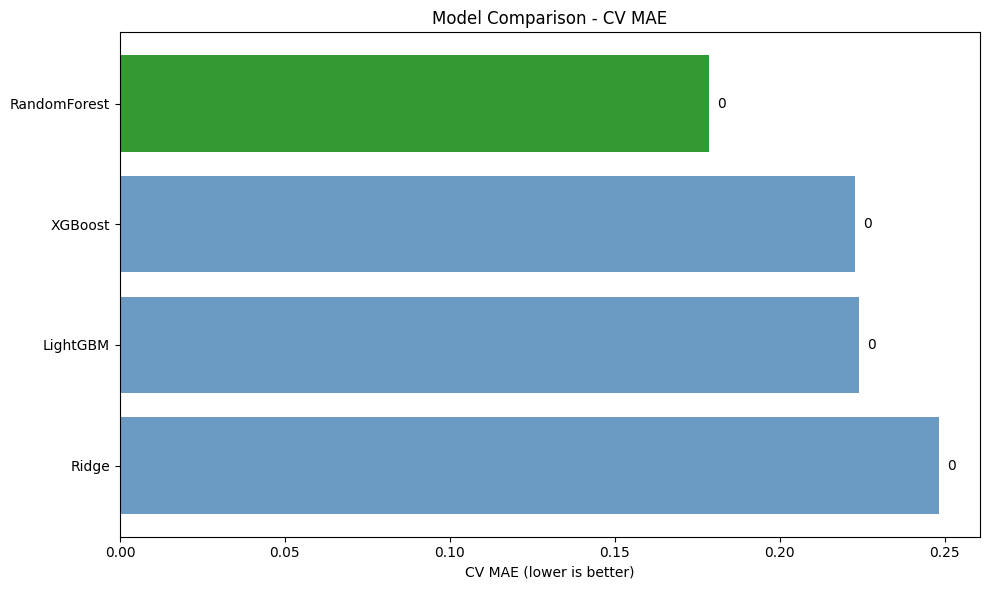

In [124]:
print("=" * 60); print("SECTION 6: VISUALIZATION"); print("=" * 60)
# Model comparison bar chart
fig, ax = plt.subplots(figsize=(10, 6))

models = results_df['Model'].tolist()
scores = results_df['Best_CV_MAE'].tolist()
colors = ['green' if m == best_model_name else 'steelblue' for m in models]

bars = ax.barh(models, scores, color=colors, alpha=0.8)
ax.set_xlabel('CV MAE (lower is better)')
ax.set_title('Model Comparison - CV MAE')
ax.invert_yaxis()

for bar, score in zip(bars, scores):
    ax.text(bar.get_width() + max(scores)*0.01, bar.get_y() + bar.get_height()/2,
            f'{score:,.0f}', va='center')

plt.tight_layout()
plt.show()

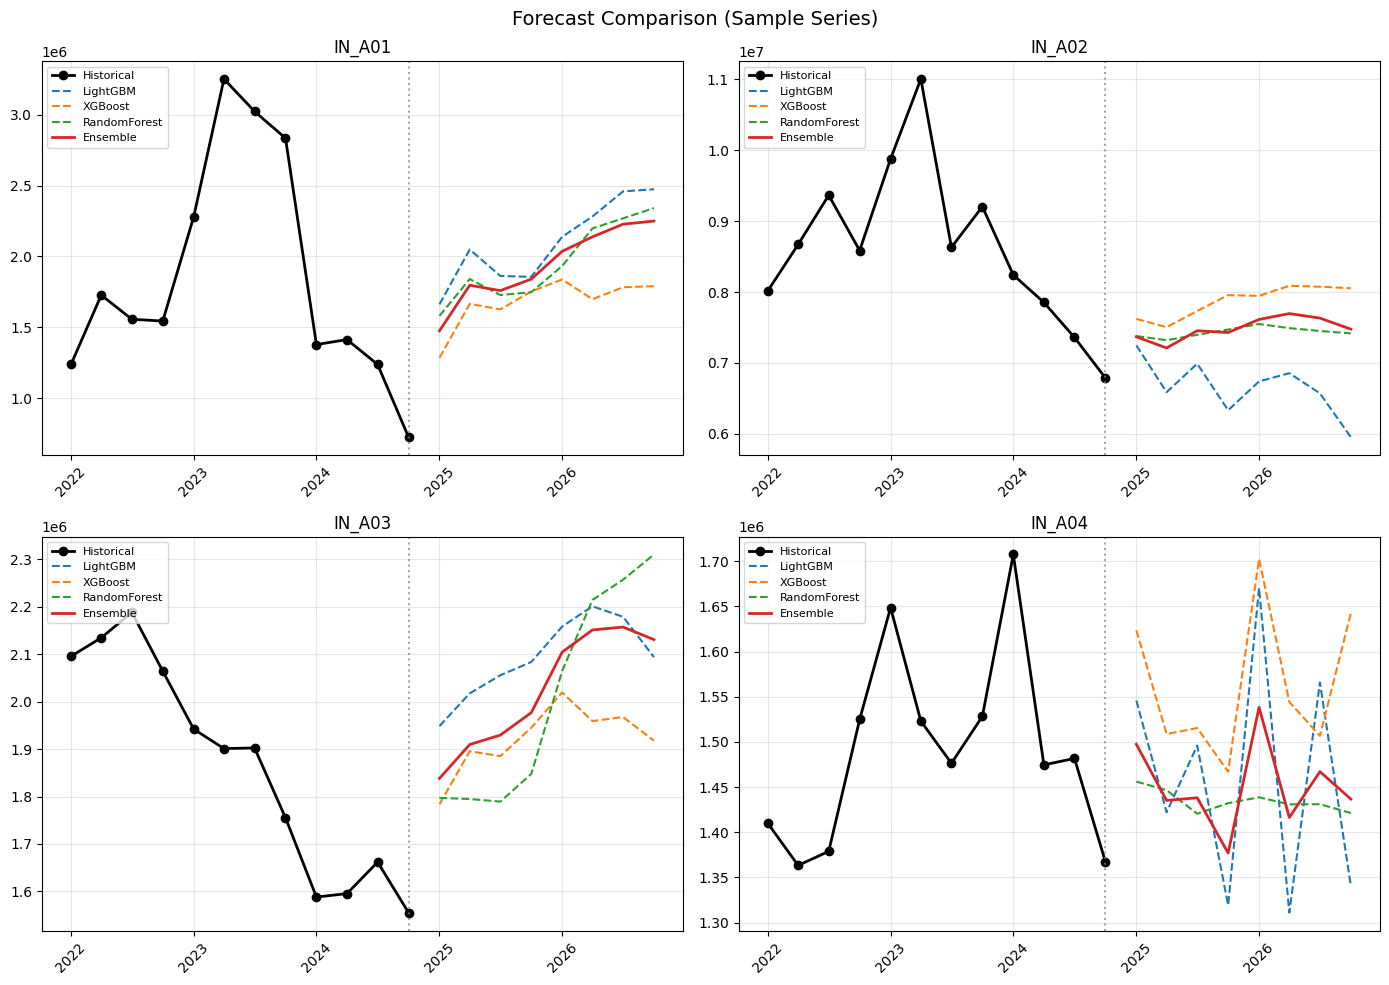

In [125]:
# Forecast comparison (sample series)
sample_ids = forecasts_point['unique_id'].unique()[:4]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, uid in enumerate(sample_ids):
    ax = axes[idx]
    
    # Historical
    hist = train_df[train_df['unique_id'] == uid].tail(12)
    ax.plot(hist['ds'], hist['y'], 'ko-', linewidth=2, label='Historical')
    
    # Forecasts
    fc = forecasts_point[forecasts_point['unique_id'] == uid]
    for model in model_cols[:3] + ['Ensemble']:
        if model in fc.columns:
            style = '-' if model == 'Ensemble' else '--'
            lw = 2 if model == 'Ensemble' else 1.5
            ax.plot(fc['ds'], fc[model], style, linewidth=lw, label=model)
    
    ax.axvline(x=train_df['ds'].max(), color='gray', linestyle=':', alpha=0.7)
    ax.set_title(f'{uid}')
    ax.legend(loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Forecast Comparison (Sample Series)', fontsize=14)
plt.tight_layout()
plt.show()

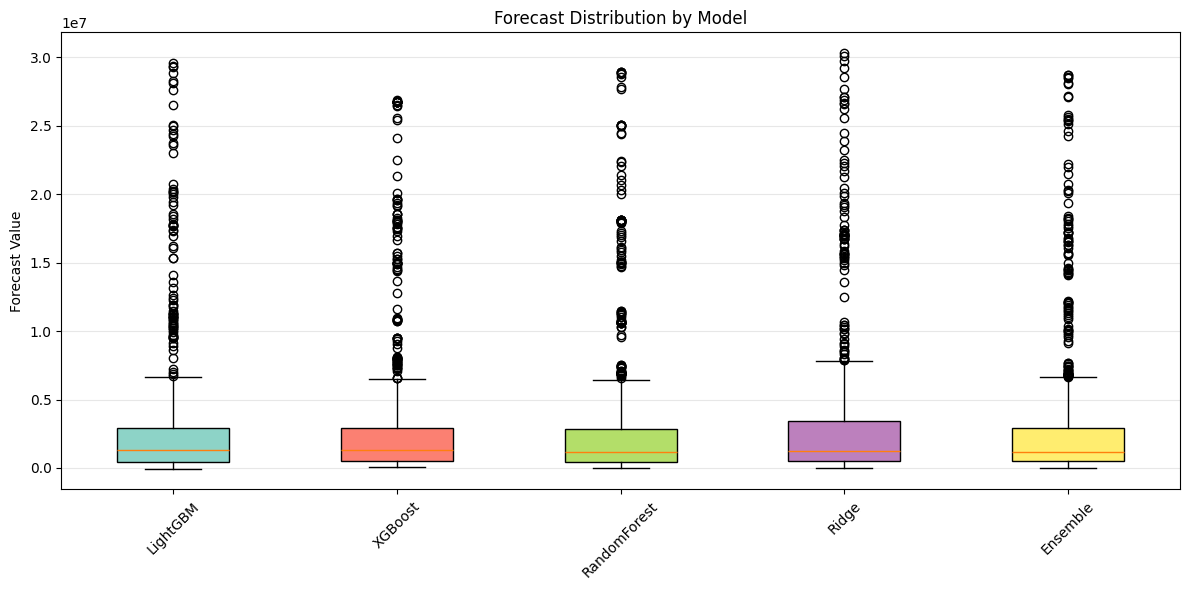

In [126]:
# Forecast distribution
fig, ax = plt.subplots(figsize=(12, 6))

all_models = model_cols + ['Ensemble']
data = [forecasts_point[m].values for m in all_models if m in forecasts_point.columns]

bp = ax.boxplot(data, labels=[m for m in all_models if m in forecasts_point.columns], patch_artist=True)
colors = plt.cm.Set3(np.linspace(0, 1, len(data)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax.set_ylabel('Forecast Value')
ax.set_title('Forecast Distribution by Model')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [127]:
# Summary statistics
print("\n" + "=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)

hist_mean = train_df['y'].mean()
print(f"\nHistorical Mean: {hist_mean:,.2f}")

print(f"\n{'Model':<15} {'Mean':>12} {'Std':>12} {'Min':>12} {'Max':>12}")
print("-" * 65)
for model in all_models:
    if model in forecasts_point.columns:
        vals = forecasts_point[model]
        print(f"{model:<15} {vals.mean():>12,.0f} {vals.std():>12,.0f} {vals.min():>12,.0f} {vals.max():>12,.0f}")


SUMMARY STATISTICS

Historical Mean: 3,240,580.26

Model                   Mean          Std          Min          Max
-----------------------------------------------------------------
LightGBM           3,466,667    5,530,901      -54,077   29,570,726
XGBoost            3,738,951    5,906,374       39,255   26,839,118
RandomForest       3,683,782    5,857,482        1,956   28,942,268
Ridge              3,820,717    5,957,242       28,263   30,295,256
Ensemble           3,674,602    5,788,452       27,414   28,685,795


## Section 7: Save Results

In [128]:
print("=" * 60)
print("SECTION 7: SAVE RESULTS")
print("=" * 60)

os.makedirs(OUTPUT_PATH, exist_ok=True)

# Forecasts
forecasts_point.to_csv(os.path.join(OUTPUT_PATH, f'{TARGET}_forecasts_point.csv'), index=False)
print(f"Saved: {TARGET}_forecasts_point.csv")

if forecasts_low is not None:
    forecasts_low.to_csv(os.path.join(OUTPUT_PATH, f'{TARGET}_forecasts_low.csv'), index=False)
    print(f"Saved: {TARGET}_forecasts_low.csv")

if forecasts_high is not None:
    forecasts_high.to_csv(os.path.join(OUTPUT_PATH, f'{TARGET}_forecasts_high.csv'), index=False)
    print(f"Saved: {TARGET}_forecasts_high.csv")

# Model comparison
results_df.to_csv(os.path.join(OUTPUT_PATH, f'{TARGET}_model_comparison.csv'), index=False)
print(f"Saved: {TARGET}_model_comparison.csv")

# Best configs
configs_to_save = {}
for model_name, cfg in best_configs.items():
    model_params = cfg.get('model_params', {})
    init_params = cfg.get('mlf_init_params', {})
    configs_to_save[model_name] = {
        'model_params': {k: v for k, v in model_params.items() 
                        if k not in ['verbosity', 'random_state', 'n_jobs']},
        'lags': init_params.get('lags'),
        'cv_mae': auto_mlf.results_[model_name].best_value,
    }

with open(os.path.join(OUTPUT_PATH, f'{TARGET}_best_configs.json'), 'w') as f:
    json.dump(configs_to_save, f, indent=2, default=str)
print(f"Saved: {TARGET}_best_configs.json")

# Models
try:
    models_path = os.path.join(OUTPUT_PATH, 'models')
    auto_mlf.save(models_path)
    print(f"Saved: models/ directory")
except Exception as e:
    print(f"Note: Could not save models: {e}")

SECTION 7: SAVE RESULTS
Saved: y_forecasts_point.csv
Saved: y_forecasts_low.csv
Saved: y_forecasts_high.csv
Saved: y_model_comparison.csv
Saved: y_best_configs.json
Saved: models/ directory


In [129]:
print("\n" + "=" * 60)
print("PIPELINE COMPLETE")
print("=" * 60)

print(f"\nSummary:")
print(f"  Target: {TARGET_NAME}")
print(f"  States: {STATES if STATES else 'All'}")
print(f"  Series: {train_df['unique_id'].nunique()}")
print(f"  Trials per model: {NUM_SAMPLES}")
print(f"  Best Model: {best_model_name} (MAE: {best_model_score:,.2f})")
print(f"  Horizon: {config.horizon} quarters")
print(f"\nOutput: {OUTPUT_PATH}")


PIPELINE COMPLETE

Summary:
  Target: Units Reimbursed
  States: ['IN']
  Series: 80
  Trials per model: 30
  Best Model: RandomForest (MAE: 0.18)
  Horizon: 8 quarters

Output: C:\Users\Lilian\OneDrive - purdue.edu\VS code\Data\ATC\Forecast\ML\\
